In [1]:
import pandas as pd
import numpy as np
import pydicom 
import os
import matplotlib.pyplot as plt

from skimage.measure import label,regionprops
from skimage.segmentation import clear_border

from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure
from skimage.transform import resize

import scipy

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv('sample_submission.csv')

In [3]:
# def load_scans(path):
#     slices = [pydicom.dcmread(path + '/' + file) for file in os.listdir(path)]
#     slices.sort(key = lambda x : float(x.ImagePositionPatient[2]))
#     return slices

In [4]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [5]:
patients = train.Patient.unique()
example = 'train/' + 'ID00419637202311204720264'
test = load_scan(example)

In [6]:
test[0].SliceThickness

"10.0"

In [8]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


imgs = get_pixels_hu(test)

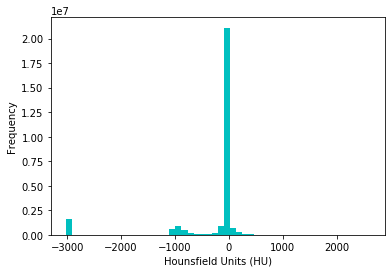

In [9]:
plt.hist(imgs.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [10]:
def crop_center(img):
    y,x = img.shape    
    return img[y//2 - 256:y//2 + 256,x//2 - 256:x//2 + 256]

In [11]:
def shape_512(array):
    
    array_512 = np.zeros([array.shape[0],512,512])
    
    for i in range(array.shape[0]):
        array_512[i] = crop_center(array[i])
        
    return array_512

# imgs_512 = np.zeros([imgs.shape[0],512,512])

# for i in range(imgs.shape[0]):
#     imgs_512[i] = crop_center(imgs[i])

In [12]:
imgs_512 = shape_512(imgs)

In [13]:
imgs_512.shape

(28, 512, 512)

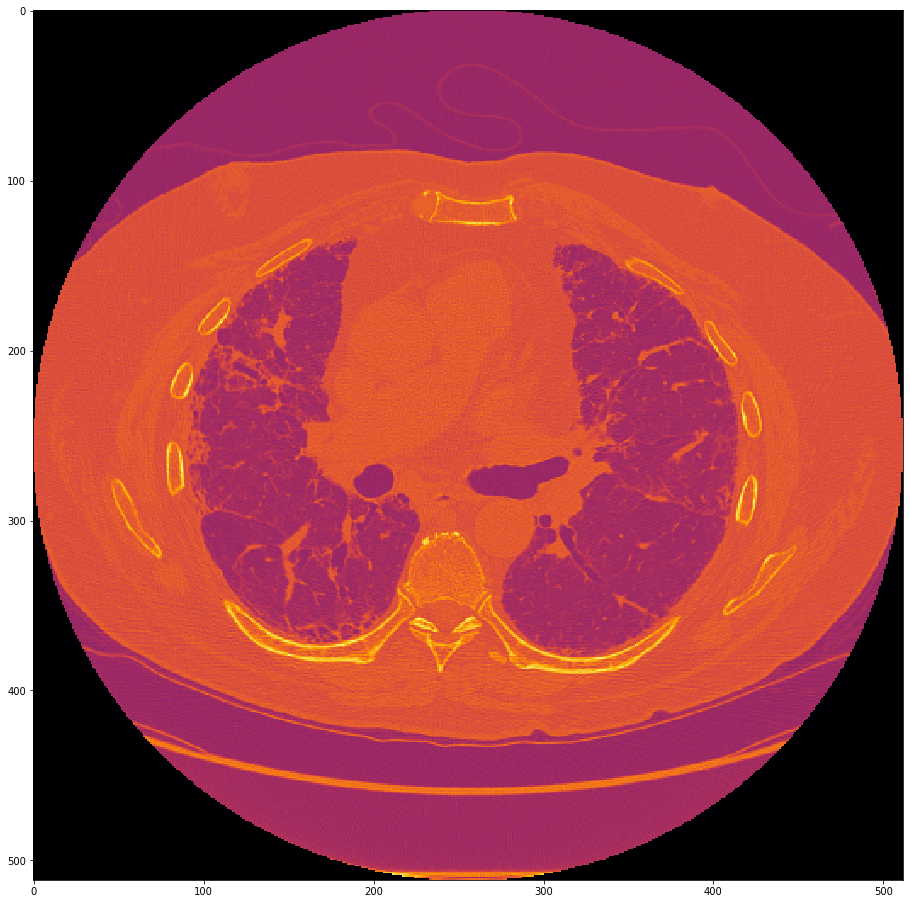

In [41]:
plt.figure(figsize=(16,16))
plt.imshow(imgs_512[15], cmap='inferno')

In [14]:
def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[20,20])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

#sample_stack(imgs)

In [15]:
print("Slice Thickness: {}".format(test[0].SliceThickness))
print("Pixel Spacing (row, col): ({},{})".format(test[0].PixelSpacing[0], test[0].PixelSpacing[1]))

Slice Thickness: 10.0
Pixel Spacing (row, col): (0.820312,0.820312)


In [50]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, [test[0].SliceThickness, test[0].PixelSpacing[0], test[0].PixelSpacing[1]])
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs.shape)
imgs_after_resamp, spacing = resample(imgs, test, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (28, 1100, 888)
Shape after resampling	 (280, 902, 728)


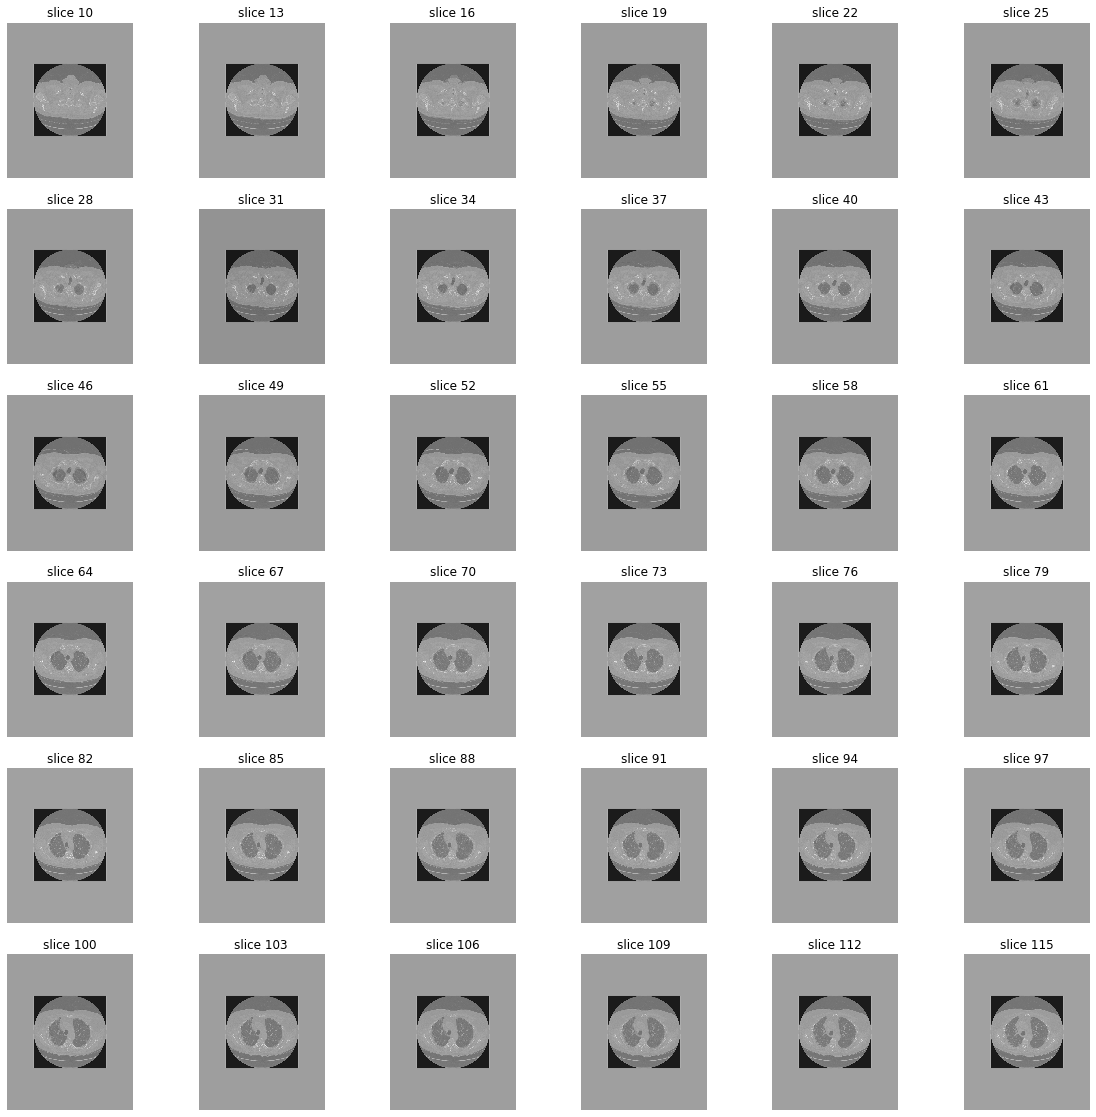

In [58]:
sample_stack(imgs_after_resamp)

In [16]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [37]:
len(imgs_512)

28

In [53]:
# def best_lungmask(slices):
#     img = make_lungmask(slices[0].pixel_array)
#     pixel_nr = (img != 0).sum()
#     for i in range(1,len(slices)):
#         tmp_img = make_lungmask(slices[i].pixel_array)
#         tmp_pixel_nr = (tmp_img != 0).sum() 
#         if tmp_pixel_nr > pixel_nr:
#             img = tmp_img
#             pixel_nr = tmp_pixel_nr
#     return img

In [38]:
def best_lungmask2(slices):
    img = make_lungmask(slices[0])
    pixel_nr = (img != 0).sum()
    nr = 0
    for i in range(1,len(slices)):
        tmp_img = make_lungmask(slices[i])
        tmp_pixel_nr = (tmp_img != 0).sum() 
        if tmp_pixel_nr > pixel_nr:
            img = tmp_img
            pixel_nr = tmp_pixel_nr
            nr = i
    return img, nr

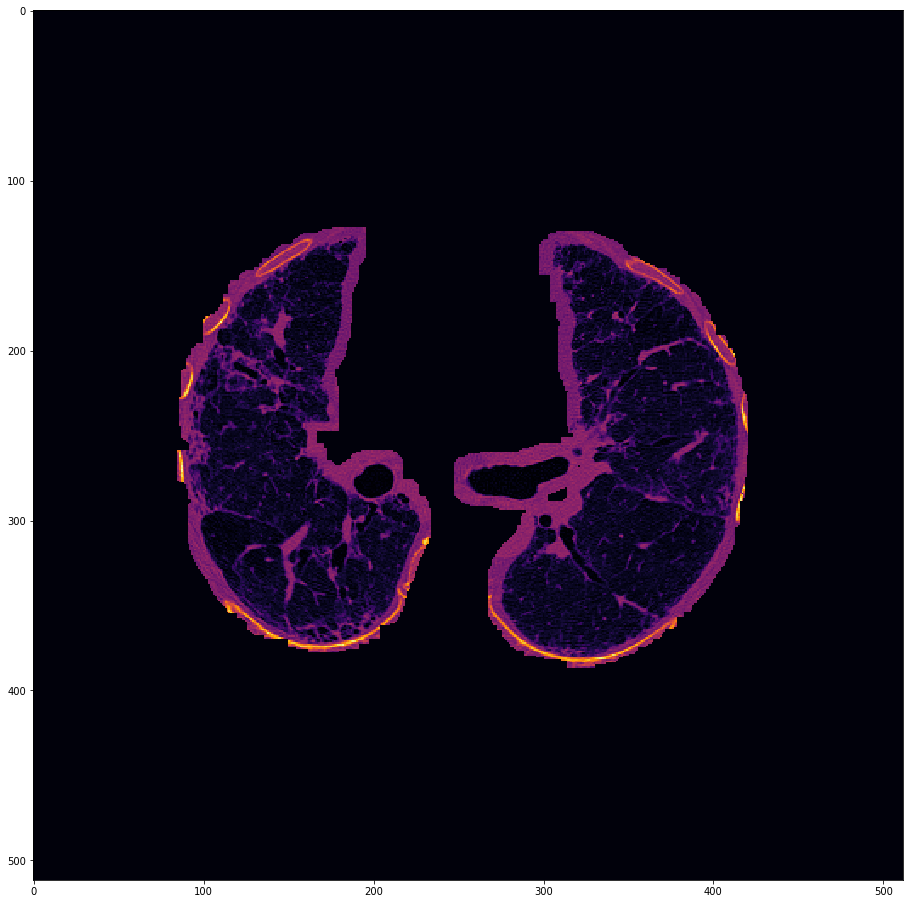

In [39]:
plt.figure(figsize=(16,16))
plt.imshow(best_lungmask2(imgs_512)[0],cmap='inferno')

In [40]:
best_lungmask2(imgs_512)[1]

15

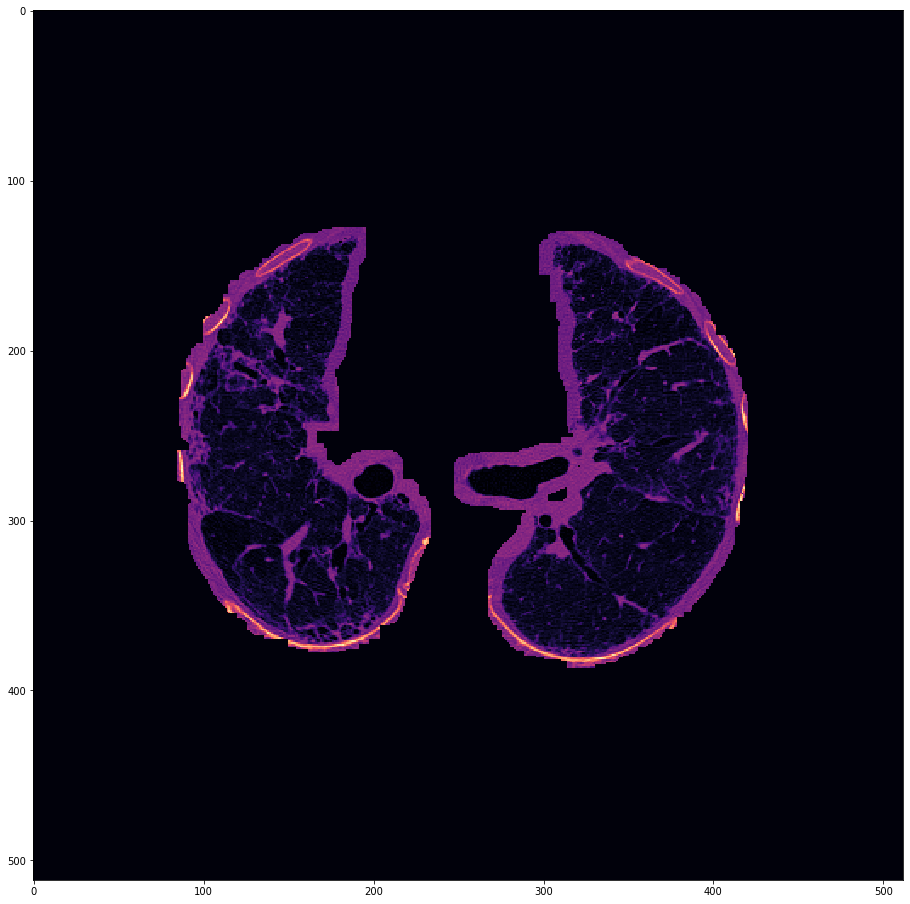

In [25]:
plt.figure(figsize=(16,16))
plt.imshow(best_lungmask2(imgs_512), cmap='magma')

In [33]:
lst = []
for pat in patients:
    
    lst.append([pydicom.dcmread('train/' + pat +'/' + file) for file in os.listdir('train/' + pat +'/')][0].pixel_array.shape)

In [35]:
lst

[Dataset.file_meta -------------------------------
 (0002, 0000) File Meta Information Group Length  UL: 200
 (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
 (0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
 (0002, 0003) Media Storage SOP Instance UID      UI: 2.25.75095883857395394118747435837043017733
 (0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
 (0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
 (0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
 (0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
 -------------------------------------------------
 (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
 (0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
 (0008, 0018) SOP Instance UID                    UI: 2.25.75095883857395394118747435837043017733
 (0008, 0060) Modality                            CS: 'CT'

In [38]:
lst2 = []
for pat in patients:
    
    lst2.append([[pydicom.dcmread('train/' + pat +'/' + file) for file in os.listdir('train/' + pat +'/')[:1]][0].pixel_array.shape, pat])

In [39]:
lst2

[[(512, 512), 'ID00007637202177411956430'],
 [(768, 768), 'ID00009637202177434476278'],
 [(512, 512), 'ID00010637202177584971671'],
 [(512, 512), 'ID00011637202177653955184'],
 [(512, 512), 'ID00012637202177665765362'],
 [(843, 888), 'ID00014637202177757139317'],
 [(768, 768), 'ID00015637202177877247924'],
 [(512, 512), 'ID00019637202178323708467'],
 [(512, 512), 'ID00020637202178344345685'],
 [(512, 512), 'ID00023637202179104603099'],
 [(768, 768), 'ID00025637202179541264076'],
 [(768, 768), 'ID00026637202179561894768'],
 [(768, 768), 'ID00027637202179689871102'],
 [(512, 512), 'ID00030637202181211009029'],
 [(512, 512), 'ID00032637202181710233084'],
 [(512, 512), 'ID00035637202182204917484'],
 [(768, 768), 'ID00038637202182690843176'],
 [(768, 768), 'ID00042637202184406822975'],
 [(512, 512), 'ID00047637202184938901501'],
 [(512, 512), 'ID00048637202185016727717'],
 [(512, 512), 'ID00051637202185848464638'],
 [(512, 512), 'ID00052637202186188008618'],
 [(512, 512), 'ID000606372021879

In [22]:
patients = train.Patient.unique()
example = 'train/' + patients[1]
example_3d = make_lungmask(load_scans(example)[200].pixel_array)

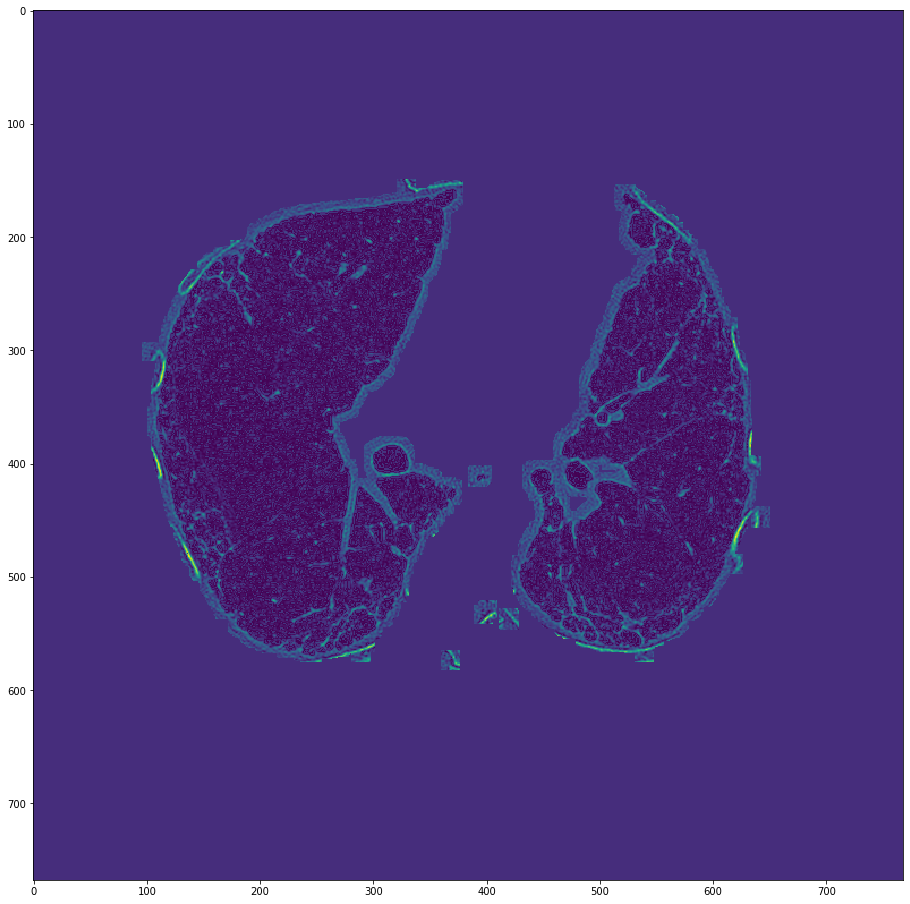

In [24]:
plt.figure(figsize = (16, 16))
plt.imshow(example_3d)

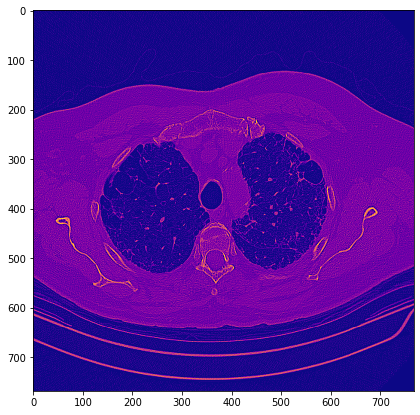

In [18]:
plt.figure(figsize = (7, 7))
plt.imshow(load_scans(example)[300].pixel_array, cmap="plasma")

In [25]:
def best_slice(array):
    tmp_best = array[0]
    pixel_nr = 0
    for i in range(1,array.shape[0]):
        if (array[i]!=0).sum() > pixel_nr:
            tmp_best = array[i]
            pixel_nr = (array[i]!=0).sum()
    return tmp_best

In [6]:
patients = train.Patient.unique()

In [26]:
train_ct_test = pd.DataFrame(index=patients[100:120], columns=['CT'])

In [27]:
for ind in train_ct_test.index:
    train_ct_test.loc[ind].CT = best_slice( make_lungmask(load_scans( 'train/' + ind  )) )

AttributeError: 'list' object has no attribute 'shape'

In [55]:
for ind in train_ct_test.index:
    np.savetxt('best_lung_slice/' + ind  + '.txt', train_ct_test.loc[ind].CT) 

In [71]:
def load_best_slices(path):
    ind = []
    for file in os.listdir(path):
        if file.split('.')[1] == 'txt':
            ind.append(file.split('.')[0])
        
    df = pd.DataFrame(index = ind, columns= ['CT'])
    for ind in df.index:
        df.loc[ind].CT = np.loadtxt(path + ind + '.txt')
    
    return df

In [72]:
df = load_best_slices('best_lung_slice/')